## Before running any of these cells
## Please refer to the information contained in the  README_Eric_chan_capstone_start_here.ipynb

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import re
import os
import sys
import shutil
from shutil import copyfile, copy2
from shutil import move

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from scipy import stats
# Cause plots to be displayed in the notebook:
%matplotlib inline

In [6]:
import subprocess 

In [5]:
from matplotlib import cm
from latt2D_modules import calc_diffuse
from latt2D_modules import get_occ_map, get_2D_occ_map_from_seq,store_occ_map_as_seq
from latt2D_modules import plot_occ_map,read_bin,output_16bit_pgm
import time

In [6]:

iconc=0.50 # spin concentration
cread=0    # reading correlation function from input file  otherwise it will be generated randomly 
'corr.in'
'jswitch.in'
icycles=200  # MC cycles 
ianneal=200  # MC input 


corrin=np.array([[1.000000,  0.000000], 
                 [0.00000,  0.000000]]) 

fhout=open('corr.in','w')
fhout.write("%.6f %.6f\n%.6f %.6f\n"%(corrin[0,0],corrin[0,1],corrin[1,0],corrin[1,1]))
fhout.close()

jsw=np.array([[1, 1], 
             [1, 1]]) 

fhout=open('jswitch.in','w')
fhout.write("%d %d\n%d %d\n"%(jsw[0,0],jsw[0,1],jsw[1,0],jsw[1,1]))
fhout.close()




### Do a Preliminary test 
### generate as random image

In [7]:
calc_diffuse(iconc,cread,icycles,ianneal,exp_no=0)
store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt','./expfiles_0/ising2D_seq.dat')

Correlation function configuration
 00: 1.000 
 01(k): -0.869 
 10(h): -0.512 
 11(hk): 0.614



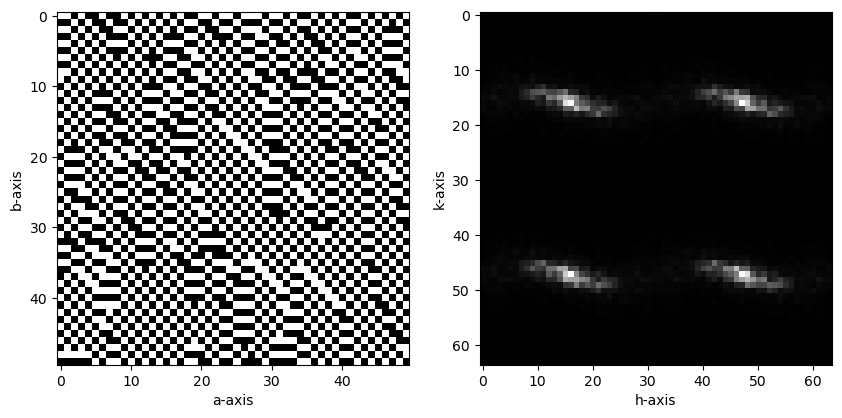

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
occ3D=get_occ_map('./expfiles_0/ising2D_occ.txt')
axes[0].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
axes[0].set_xlabel('a-axis')
axes[0].set_ylabel('b-axis')
imdat = read_bin('./expfiles_0/hk0.bin', npixels=64, offset=1280)
axes[1].imshow(np.flip(imdat,0),cmap='gray')
axes[1].set_xlabel('h-axis')
axes[1].set_ylabel('k-axis')
corr_out=np.loadtxt('expfiles_0/corr.out')
print("Correlation function configuration")
print(" 00: %.3f \n 01(k): %.3f \n 10(h): %.3f \n 11(hk): %.3f\n"%tuple(corr_out.flatten()))

#### below is a check to see how the reinput changes - in future we can check using a few differnt metrics 
#### but for the time being the correlation function will act as the decoder for generating the crystal  

Correlation function configuration
 00: 0.999 
 01(k): -0.879 
 10(h): -0.510 
 11(hk): 0.594



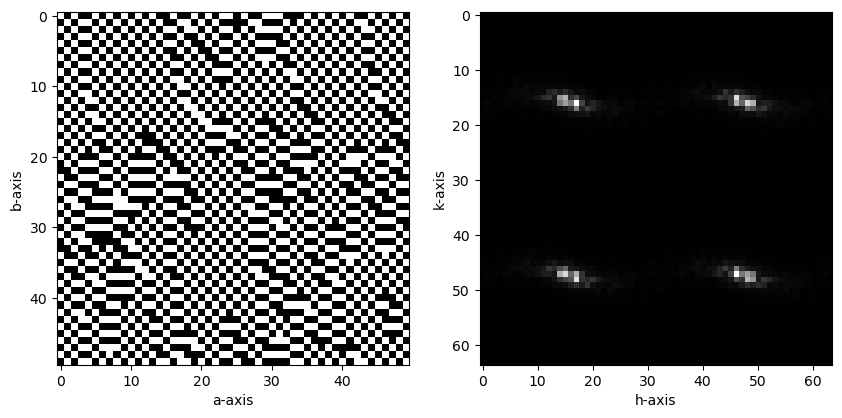

In [9]:
copyfile('expfiles_0/corr.out','./corr.in')
calc_diffuse(iconc,1,icycles,ianneal,1)
store_occ_map_as_seq('./expfiles_1/ising2D_occ.txt','./expfiles_1/ising2D_seq.dat')
fig, axes = plt.subplots(1, 2, figsize=(10,6))
occ3D=get_occ_map('./expfiles_1/ising2D_occ.txt')
axes[0].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
axes[0].set_xlabel('a-axis')
axes[0].set_ylabel('b-axis')
imdat = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
axes[1].imshow(np.flip(imdat,0),cmap='gray')
axes[1].set_xlabel('h-axis')
axes[1].set_ylabel('k-axis')
corr_out=np.loadtxt('expfiles_1/corr.out')
print("Correlation function configuration")
print(" 00: %.3f \n 01(k): %.3f \n 10(h): %.3f \n 11(hk): %.3f\n"%tuple(corr_out.flatten()))

### Lets calculate an accuracy and MSE for the correaltion functions as well as the images 
### we will use this as a modified baseline accuracy since the binary grid will also have intrinsic baseline acc 

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [11]:
occ2D_0=get_2D_occ_map_from_seq('./expfiles_0/ising2D_seq.dat')
occ2D_1=get_2D_occ_map_from_seq('./expfiles_1/ising2D_seq.dat')
accuracy=sum(occ2D_0==occ2D_1)/len(occ2D_0.flatten())
print("Ising2D accuracy:", accuracy)
corr_out_0=np.loadtxt('expfiles_0/corr.out')
corr_out_1=np.loadtxt('expfiles_1/corr.out')
imdat_0 = read_bin('./expfiles_0/hk0.bin', npixels=64, offset=1280)
imdat_1 = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
print("MSE correlation config: ", mean_squared_error(corr_out_0,corr_out_1))
print("MSE FT images: ", mean_squared_error(imdat_0,imdat_1))

Ising2D accuracy: 0.5344
MSE correlation config:  0.00012578600099999877
MSE FT images:  0.42049676


## The below cell will generate random images which can be used for training a CNN
## The correlations are stored in a dataframe which is then saved as a .csv 

In [ ]:
# %%timeit # you need to be careful with this becasue magic function acts like wrapper and screws with variable locality
# in fact its running the loop several times to get an average - if you want the time for a single run just import time

start_time = time.time()
# when possible always dump to a list or array before converting to Dataframe
N=3000 # make this many images
Nstart=2000 # start labels here
corrfuncs=[]
for i in range(N):
    k=i+Nstart
    calc_diffuse(iconc,0,icycles,ianneal,exp_no=0)
    copyfile('./expfiles_0/hk0.bin','./image_inputs_bin/hk0_%s.bin'% str(k).zfill(6))
    store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt','./image_inputs_seq/ising2D_seq_%s.dat' %  str(k).zfill(6))
    # dont save the full occfile unless needed - since this takes up resources 
    # copyfile('./expfiles_0/ising2D_occ.txt','./image_inputs_occ/ising2D_occ_%d.txt'%(i))  
    corr_out=np.loadtxt('expfiles_0/corr.out')
    corrfuncs.append(corr_out.flatten())
    
end_time = time.time()
total_time = end_time - start_time

print("Total time taken: {:.2f} seconds".format(total_time))

### dont forget to relabel the DF if you are making a new batch

In [15]:
df=pd.DataFrame(corrfuncs)
df.columns=['00','01','10','11']
df.to_csv('output_correlations_3000.csv')
df

,00,01,10,11
0,0.999892,-0.321708,0.507092,0.161492
1,0.999567,0.487567,0.108367,0.085967
2,0.999856,0.047856,0.007856,0.332656
3,0.999948,-0.422452,0.196748,-0.755252
4,0.999908,0.396708,0.337508,-0.260892
...,...,...,...,...
2995,0.999718,-0.787482,-0.230682,0.076518
2996,0.997847,-0.293353,-0.365353,0.284247
2997,0.998871,0.392471,-0.025129,0.573271
2998,0.999600,-0.104400,-0.454800,0.636400


In [64]:
# below code is a bit  buggy and needs updating 
from matplotlib.colors import ListedColormap

a = 1.0  #  if you set this to lower value it start to darken the map. if you leave at 1.0 it end up as grays'
# Get the colormap colors, multiply them with the factor "a", and create new colormap
# my_cmap = plot.cm.BrBG(np.arange(plot.cm.BrBG.N))
# my_cmap = plot.cm.summer(np.arange(plot.cm.summer.N))
my_cmap = plt.cm.gray(np.arange(plt.cm.gray.N))
# hackjob by EJC 
# the offset has the effect of brightening the colormap 
# so that is roughly looks like what I wanted 
my_cmap[:,0:3] *= a 
# my_cmap[:,0:3] += 0.2
my_cmap = ListedColormap(my_cmap)


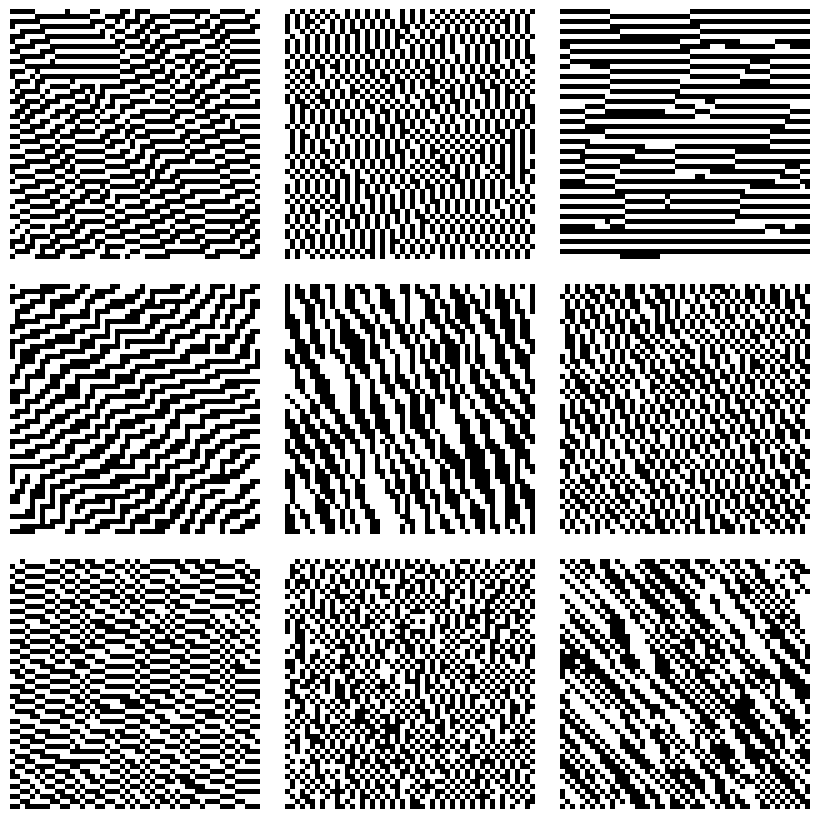

In [11]:
rows,cols =3,3 
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
Nstart=0 # start labels here
k=0
for i in range(rows): 
    for j in range(cols):
        # occ3D=get_occ_map('./image_inputs_occ/ising2D_occ_%d.txt'%(k))
        # axes[i,j].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap=my_cmap) 
        occ2D=get_2D_occ_map_from_seq('./image_inputs_seq/ising2D_seq_%s.dat'%str(k+Nstart).zfill(6))
        axes[i,j].imshow(np.transpose(occ2D),cmap='gray')
        axes[i,j].axis('off')
       # axes[i,j].set_xlabel('a-axis')
       # axes[i,j].set_ylabel('b-axis')

        k+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)


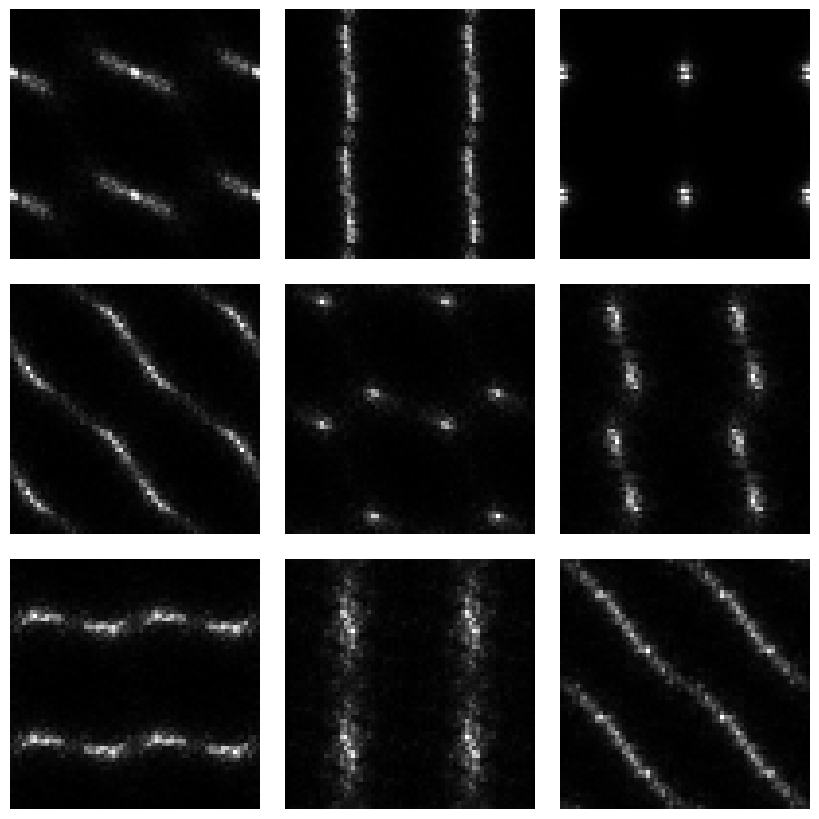

In [12]:
rows,cols =3,3 
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
Nstart=0 # start labels here
k=0
for i in range(rows): 
    for j in range(cols):
        imdat = read_bin('./image_inputs_bin/hk0_%s.bin'%str(k+Nstart).zfill(6), npixels=64, offset=1280)
        axes[i,j].imshow(np.flip(imdat,0),cmap='gray')
        axes[i,j].axis('off')
        axes[i,j].set_xlabel(None)
        k+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)

## below is test code 

In [180]:
# this stores the output simualtion as a string of ones and zeros
x=np.loadtxt('./expfiles_0/ising2D_occ.txt',usecols=[4])
fhout=open('ising2D_seq.dat','w')
fhout.write(''.join(list((x-1).astype(int).astype(str))))
fhout.close()

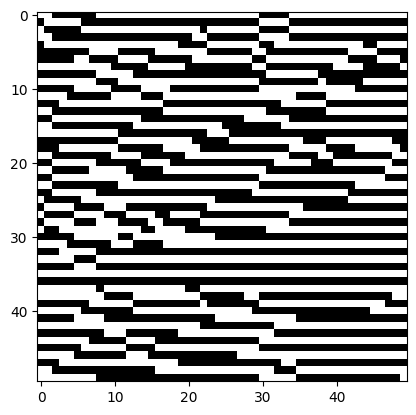

In [175]:
#. in order to plot we can read this back into a diffrent routine 
with open('ising2D_seq.dat','r') as f:
    myseq=f.read()
myocc=np.array(list(myseq)).astype(int).reshape((50,50))
plt.imshow(np.transpose(myocc),interpolation='nearest',cmap=my_cmap) 

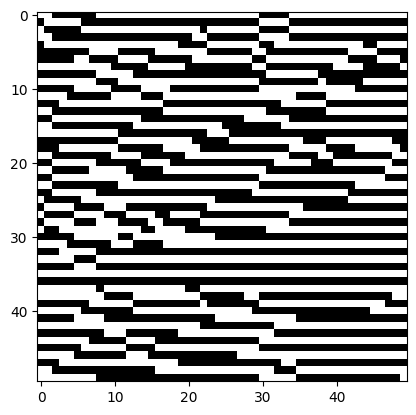

In [176]:
occ3D=get_occ_map('./expfiles_0/ising2D_occ.txt')
plt.imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap=my_cmap) 

In [177]:
df.tail()

,00,01,10,11
10,0.999969,0.012769,-0.331231,0.643169
11,0.997921,0.804321,0.674721,0.501921
12,0.999892,-0.003308,0.719892,-0.179308
13,0.999936,-0.656064,-0.726464,0.551936
14,0.999999,-0.672001,0.804799,-0.507201


In [182]:
store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt', 'ising2D_seq.dat')

In [183]:
occ2d=get_2D_occ_map_from_seq('ising2D_seq.dat')

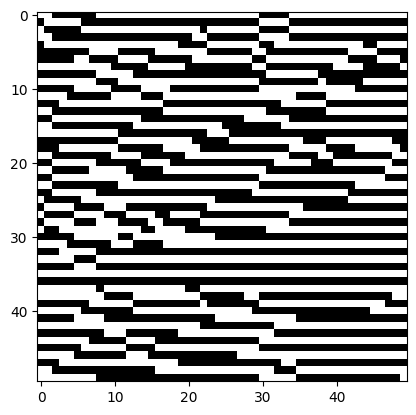

In [185]:
plt.imshow(np.transpose(occ2d),interpolation='nearest',cmap=my_cmap) 

In [19]:
# save the data as .h5

import h5py

# Set the path to your images directory
img_dir = "./image_inputs_bin/"

# Set the size of your images
img_size = (64, 64)

# Set the path to where you want to save the HDF5 file
h5_file = "./image_dataset_1000.h5"

nfiles=1000
Nstart=0 
# Create a new HDF5 file
with h5py.File(h5_file, 'w') as hf:

    # Create a dataset to store your image data
    img_data = hf.create_dataset('img_data', shape=(nfiles, *img_size), dtype=np.float64)

    # Loop through each image file
    for i in range(nfiles):    
        
        # Convert the image to a numpy array
        img_arr =read_bin(img_dir+'hk0_%s.bin'%str(i+Nstart).zfill(6), npixels=64, offset=1280)
        
        # Store the image data in the dataset
        img_data[i] = img_arr

# Print a message indicating the dataset has been created
print("Dataset created in {}".format(h5_file))


Dataset created in ./image_dataset_1000.h5


In [24]:
# save the 5000 data images as .h5

import h5py

# Set the path to your images directory
img_dir = "./image_inputs_bin/"

# Set the size of your images
img_size = (64, 64)

# Set the path to where you want to save the HDF5 file
h5_file = "./image_dataset_5000.h5"

nfiles=5000
Nstart=0 
# Create a new HDF5 file
with h5py.File(h5_file, 'w') as hf:

    # Create a dataset to store your image data
    img_data = hf.create_dataset('img_data', shape=(nfiles, *img_size), dtype=np.float64)

   
    # Loop through each image file
    for i in range(nfiles):    
        
        # Convert the image to a numpy array
        img_arr =read_bin(img_dir+'hk0_%s.bin'%str(i+Nstart).zfill(6), npixels=64, offset=1280)
        
        # Store the image data in the dataset
        img_data[i] = img_arr

        
        
# Print a message indicating the dataset has been created
print("Dataset created in {}".format(h5_file))


Dataset created in ./image_dataset_5000.h5


In [20]:
# Open the HDF5 file in read-only mode
with h5py.File('image_dataset_1000.h5', 'r') as f:
    # Get a list of dataset names in the HDF5 file
    dataset_names = list(f.keys())
    
    # Print the names of all datasets
    for name in dataset_names:
        print(name)
    dset=f['img_data']
    X=dset[:]

img_data


In [21]:
np.shape(X)

(1000, 64, 64)

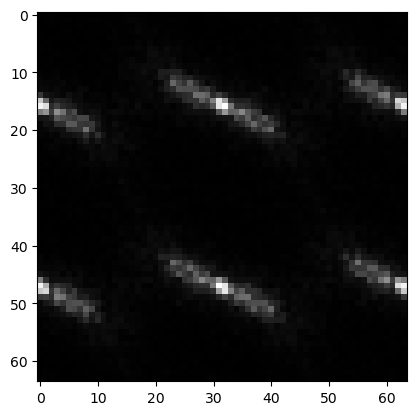

In [22]:
imshow(np.flip(X[0],0),cmap='gray')

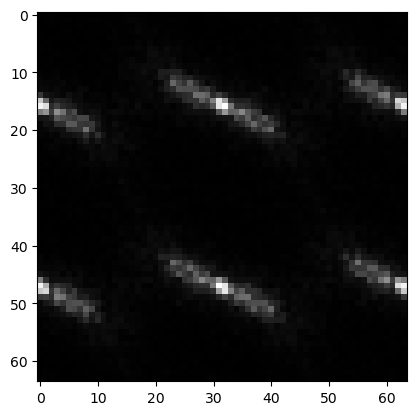

In [23]:
k=0
imdat = read_bin('./image_inputs_bin/hk0_%s.bin'%str(k).zfill(6), npixels=64, offset=1280)
imshow(np.flip(imdat,0),cmap='gray')